In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from tqdm import tqdm

In [2]:
data_temp = np.load("data/temp.npy").transpose((0, 2, 1))
data_wind = np.load("data/wind.npy").transpose((0, 2, 1))
data_varb = np.load("data/global_data.npy")
data_varb = np.repeat(data_varb, 3, axis=0)[: len(data_temp), :, :, :]
data_varb = data_varb.reshape(data_varb.shape[0], -1, data_varb.shape[3])
data = np.concatenate([data_temp, data_wind, data_varb], axis=1).transpose((2, 0, 1))
num_station, time_len, n_var = data.shape  # (3850, 17544, 38)

In [3]:
seq_len = 24 * 7
pred_len = 24 * 1

In [4]:
def interval(data):
    return data.max() - data.min()

In [6]:
temp_corr_all = []
wind_corr_all = []
for s_idx in tqdm(range(0, num_station)):
    df = pd.DataFrame(columns=list(range(data.shape[-1])), data=data[s_idx])
    append_data = []
    # for i in range(n_var - 2):
    #     append_data.append(df[i + 2].diff().fillna(0))
    #     for windws_size in [24, 168]:
    #         temp = df[i + 2].rolling(window=windws_size)
    #         append_data.append(temp.max().fillna(0))
    #         append_data.append(temp.min().fillna(0))
    #         append_data.append(temp.kurt().fillna(0))
    #         append_data.append(temp.skew().fillna(0))
    #         append_data.append(temp.std().fillna(0))
    #         append_data.append(temp.sum().fillna(0))
    #         append_data.append(temp.sem().fillna(0))
    #         append_data.append(temp.cov().fillna(0))
    #         append_data.append(temp.mean().fillna(0))
    #         append_data.append(temp.apply(interval).fillna(0))
    # df_a = pd.DataFrame(data=np.array(append_data).T)
    # df_a.columns = list(range(len(df.columns), len(df.columns) + len(append_data), 1))
    # df_all = pd.concat([df, df_a], axis=1)
    temp_corr = []
    wind_corr = []
    for i in range(len(df.columns) - 2):
        temp_corr.append(abs(df.iloc[:, i + 2].corr(df.iloc[:, 0])))
        wind_corr.append(abs(df.iloc[:, i + 2].corr(df.iloc[:, 1])))
    temp_corr_all.append(temp_corr)
    wind_corr_all.append(wind_corr)
temp_corr_all = np.array(temp_corr_all)
wind_corr_all = np.array(wind_corr_all)

  1%|          | 32/3850 [00:02<03:49, 16.63it/s]/data01/student1/.conda/envs/BDC/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data01/student1/.conda/envs/BDC/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 3850/3850 [03:09<00:00, 20.31it/s]


In [7]:
np.sum(np.nan_to_num(temp_corr_all) > 0.9, axis=0)

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 2985, 3049, 3090, 3070,
       3163, 3220, 3119, 3240, 3291,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

In [9]:
np.sum(np.nan_to_num(wind_corr_all) > 0.5, axis=0)

array([158, 166, 163, 185, 191, 200, 192, 224, 239,  66,  74,  76,  81,
        91,  99,  83,  88, 104,  55,  48,  41,  52,  51,  52,  51,  54,
        51,   1,   0,   1,   1,   0,   1,   1,   0,   1])

In [104]:
data_varb.shape

(17544, 36, 3850)

In [138]:
def corr(df1, df2):
    return [df2.iloc[:, i].corr(df1) for i in range(27)]

temp_corr = []
wind_corr = []
for s in tqdm(range(data_varb.shape[-1])):
    df = pd.DataFrame(data=data_varb[:, :27, s], columns=list(range(27)))
    df.diff().fillna(0.0)
    corr(df.iloc[:, 0], df.diff().fillna(0.0))
    temp = df.rolling(window=24)
    temp.mean().fillna(0.0).to_numpy()
    temp.std().fillna(0.0).to_numpy()
    temp.skew().fillna(0.0).to_numpy()
    temp.kurt().fillna(0.0).to_numpy()
    temp.median().fillna(0.0).to_numpy()
    temp.max().fillna(0.0).to_numpy()
    temp.min().fillna(0.0).to_numpy()
    df.iloc[:, :9].mean(axis=1).fillna(0.0).to_numpy().reshape(-1, 1)
    df.iloc[:, 9:18].mean(axis=1).fillna(0.0).to_numpy().reshape(-1, 1)
    df.iloc[:, 18:27].mean(axis=1).fillna(0.0).to_numpy().reshape(-1, 1)
    for i in range(9):        
        np.sqrt(df.iloc[:, i] ** 2 + df.iloc[:, i+9] ** 2).to_numpy().reshape(-1, 1)


100%|██████████| 3850/3850 [25:33<00:00,  2.51it/s]


In [2]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "/data01/student1/.cache/huggingface/hub/models--amazon--chronos-t5-small/snapshots/476a71b73e6205f7987e811a81f355b9791c9256",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# forecast shape: [num_series, num_samples, prediction_length]
forecast = pipeline.predict(
    context=torch.tensor(df["#Passengers"]),
    prediction_length=12,
    num_samples=20,
)

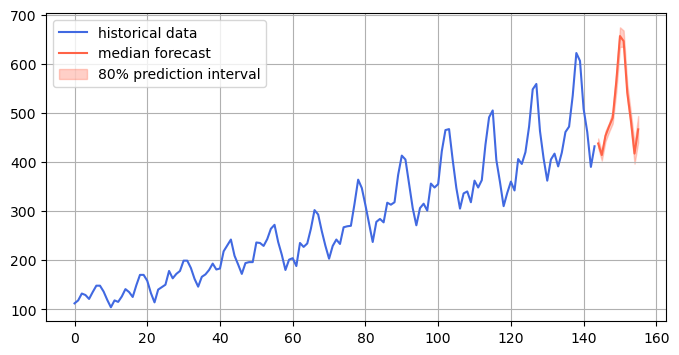

In [3]:
import matplotlib.pyplot as plt  # requires: pip install matplotlib
import numpy as np

forecast_index = range(len(df), len(df) + 12)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [4]:
forecast.shape

torch.Size([1, 20, 12])

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import time
from scipy import stats
from tqdm import tqdm

import matplotlib.pyplot as plt

from IPython.display import clear_output as clear

In [2]:
data_temp = np.load("/BDC_data/temp.npy")  # (T, S, 1)
data_temp = data_temp.transpose((0, 2, 1))  # (T 1 S)
data_wind = np.load("/BDC_data/wind.npy")  # (T, S, 1)
data_wind = data_wind.transpose((0, 2, 1))  # (T 1 S)

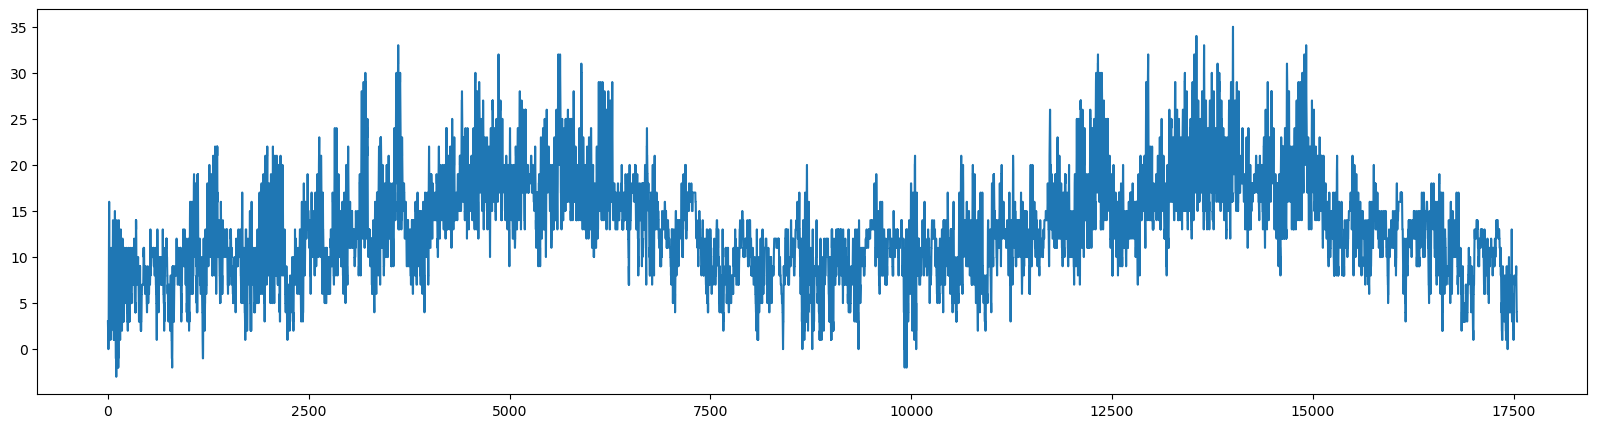

KeyboardInterrupt: 

In [4]:
for i in range(3850):
    plt.figure(figsize=(20, 5))
    plt.cla()
    plt.plot(data_wind[:, 0, i])
    plt.show()
    time.sleep(1)
    clear()

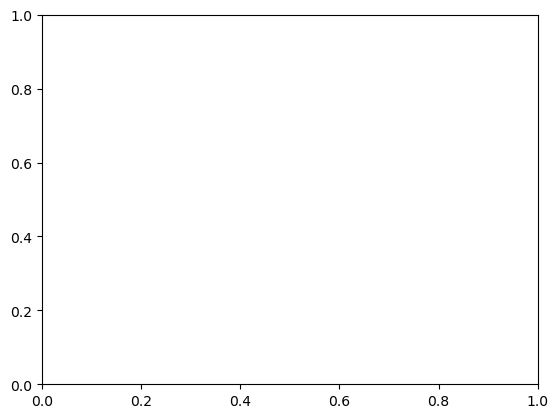

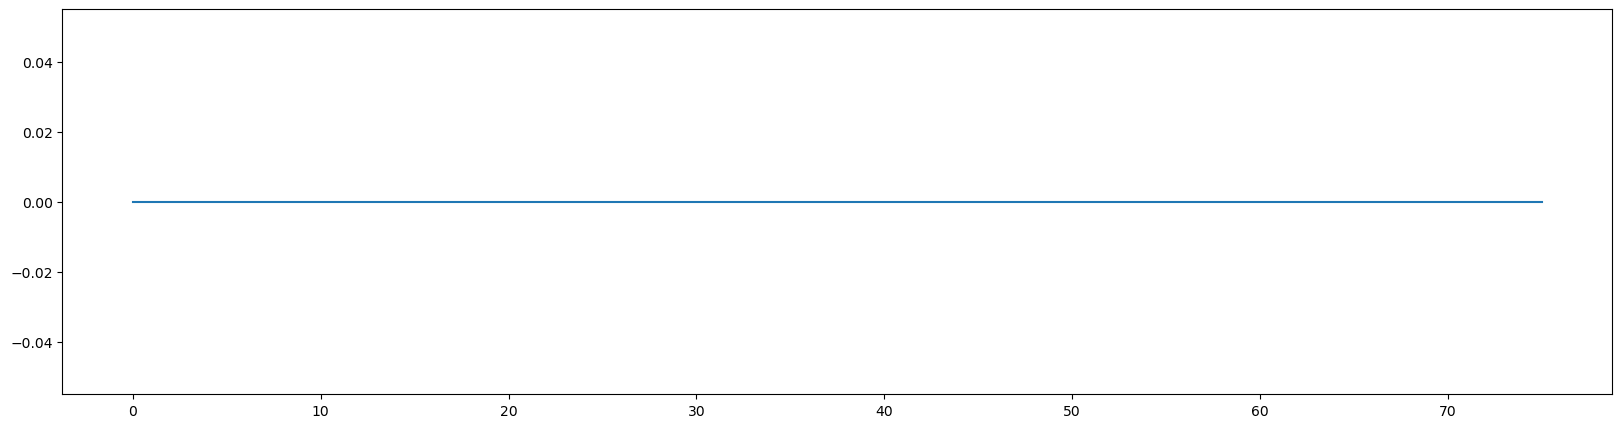

In [9]:
_temp = data_temp[..., np.std(data_temp, axis=0) == 0]
plt.cla()
plt.figure(figsize=(20, 5))
plt.plot(_temp[0])

In [3]:
mask = (np.std(data_temp, axis=0) == 0) | (np.std(data_wind, axis=0).squeeze() == 0)
mask = ~mask.squeeze()

In [4]:
data_temp = data_temp[..., mask]

In [8]:
data_temp.squeeze()[-168:].std(axis=0).mean()

3.383935935011419

In [35]:
((data_temp[:240,0,:] == stats.mode(data_temp[:240,0,:], keepdims=True)[0][0]).sum(axis=0) / 240).min()

0.016666666666666666

In [36]:
_data_temp = data_temp.squeeze()
vars = []
modes = []
for s in tqdm(range(0, data_temp.shape[0] - 239, 1)):
    _data = _data_temp[s:s+240, ...]
    v = _data.var(axis=0)
    vars.append(v)
    a = stats.mode(_data, keepdims=True)[0][0]
    modes.append((_data == a).sum(axis=0) / len(_data))
vars = np.stack(vars).T
modes = np.stack(modes).T

100%|██████████| 17305/17305 [18:48<00:00, 15.34it/s]


In [40]:
vars.shape, modes.shape

((3651, 17305), (3651, 17305))

In [43]:
vars = vars.flatten()
modes = modes.flatten()

(array([1.0302397e+07, 1.4486757e+07, 1.1820492e+07, 9.1274760e+06,
        6.4964990e+06, 4.2571230e+06, 2.5714930e+06, 1.5025090e+06,
        8.9465000e+05, 5.5532900e+05, 3.5525500e+05, 2.3710800e+05,
        1.5539500e+05, 1.0913700e+05, 7.6553000e+04, 5.4760000e+04,
        3.9640000e+04, 2.9244000e+04, 2.1934000e+04, 1.6915000e+04,
        1.3971000e+04, 1.0886000e+04, 8.9200000e+03, 7.1480000e+03,
        5.0580000e+03, 3.9780000e+03, 3.2200000e+03, 2.5000000e+03,
        1.9820000e+03, 1.6360000e+03, 1.4760000e+03, 1.3920000e+03,
        1.3520000e+03, 1.2970000e+03, 9.0600000e+02, 8.2400000e+02,
        8.3800000e+02, 7.3200000e+02, 5.8700000e+02, 3.2200000e+02,
        3.0900000e+02, 3.0500000e+02, 1.3600000e+02, 1.6000000e+01,
        2.1000000e+01, 3.3000000e+01, 6.0000000e+00, 1.0000000e+01,
        1.7000000e+01, 1.1000000e+01]),
 array([  0.        ,   5.70551408,  11.41102816,  17.11654224,
         22.82205632,  28.5275704 ,  34.23308448,  39.93859856,
         45.6441

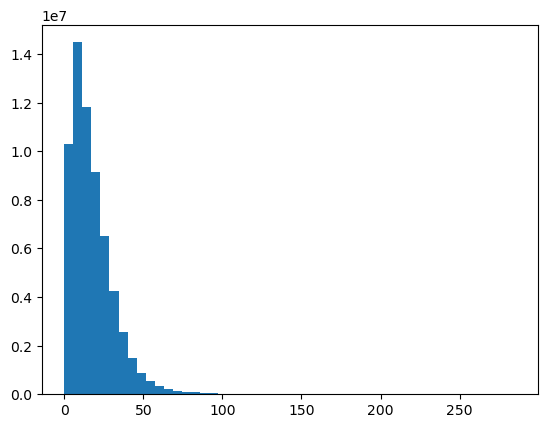

In [174]:
plt.hist(vars, bins=50)

In [64]:
(vars < 2.7).sum() / len(vars)  # temp window var  < 5%

0.05001883886585042

In [78]:
(vars > 43.2).sum() / len(vars)  #  temp window var > 95%

0.050095128160871645

(array([1.5672915e+07, 1.8794442e+07, 6.5638410e+06, 3.8439760e+06,
        4.2635030e+06, 3.2307510e+06, 2.4167980e+06, 1.5243250e+06,
        1.5378730e+06, 1.1777780e+06, 8.9022900e+05, 5.4675800e+05,
        5.0993100e+05, 3.7180500e+05, 3.0104600e+05, 1.6984000e+05,
        1.7990700e+05, 1.3134900e+05, 1.0325600e+05, 6.7595000e+04,
        7.4438000e+04, 5.4207000e+04, 4.1276000e+04, 2.9081000e+04,
        3.1604000e+04, 2.5948000e+04, 1.7674000e+04, 2.5804000e+04,
        2.3959000e+04, 1.7786000e+04, 1.1091000e+04, 1.2216000e+04,
        1.1563000e+04, 3.7914000e+04, 8.1020000e+03, 1.0640000e+04,
        1.0076000e+04, 8.6140000e+03, 8.4190000e+03, 9.7800000e+03,
        8.2600000e+03, 7.5600000e+03, 6.0290000e+03, 8.1810000e+03,
        7.7850000e+03, 2.3171000e+04, 8.4620000e+03, 7.1720000e+03,
        7.4420000e+03, 3.2838300e+05]),
 array([0.0125 , 0.03225, 0.052  , 0.07175, 0.0915 , 0.11125, 0.131  ,
        0.15075, 0.1705 , 0.19025, 0.21   , 0.22975, 0.2495 , 0.26925,
  

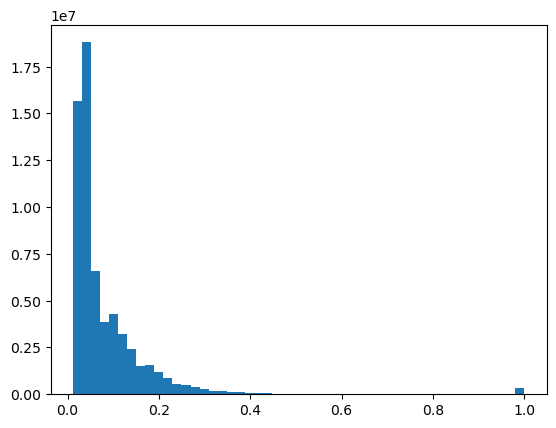

In [80]:
plt.hist(modes, bins=50)

In [155]:
(modes > 0.1745).sum() / len(modes)  #  temp window modes > 90%

0.10331347991482506

In [37]:
data_wind = data_wind[..., mask]

In [38]:
_data_wind = data_wind.squeeze()
vars_wind = []
modes_wind = []
for s in tqdm(range(0, _data_wind.shape[0] - 239, 1)):
    _data = _data_wind[s:s+240, ...]
    v = _data.var(axis=0)
    vars_wind.append(v)
    a = stats.mode(_data, keepdims=True)[0][0]
    modes_wind.append((_data == a).sum(axis=0) / len(_data))
vars_wind = np.stack(vars_wind).T
modes_wind = np.stack(modes_wind).T

100%|██████████| 17305/17305 [18:07<00:00, 15.92it/s]


In [157]:
vars_wind = vars_wind.flatten()
modes_wind = modes_wind.flatten()

(array([4.4376207e+07, 1.3506948e+07, 3.2884080e+06, 1.1139480e+06,
        4.4414100e+05, 2.0293700e+05, 1.0206500e+05, 5.3912000e+04,
        3.2953000e+04, 1.7873000e+04, 1.2739000e+04, 7.8590000e+03,
        4.9250000e+03, 3.5030000e+03, 2.8220000e+03, 2.4230000e+03,
        1.7510000e+03, 9.8400000e+02, 1.0910000e+03, 6.7000000e+02,
        7.2100000e+02, 4.8700000e+02, 2.2300000e+02, 8.9000000e+01,
        9.3000000e+01, 1.5600000e+02, 5.7000000e+01, 7.9000000e+01,
        5.7000000e+01, 1.1000000e+01, 3.8000000e+01, 1.6000000e+01,
        1.9000000e+01, 6.1000000e+01, 4.6000000e+01, 1.0000000e+01,
        1.8000000e+01, 1.5000000e+01, 1.6000000e+01, 2.2000000e+01,
        1.7000000e+01, 9.0000000e+00, 9.0000000e+00, 1.1000000e+01,
        1.2000000e+01, 9.0000000e+00, 3.0000000e+01, 1.9000000e+01,
        2.1000000e+01, 2.5000000e+01]),
 array([  0.        ,   4.87090311,   9.74180622,  14.61270933,
         19.48361244,  24.35451556,  29.22541867,  34.09632178,
         38.9672

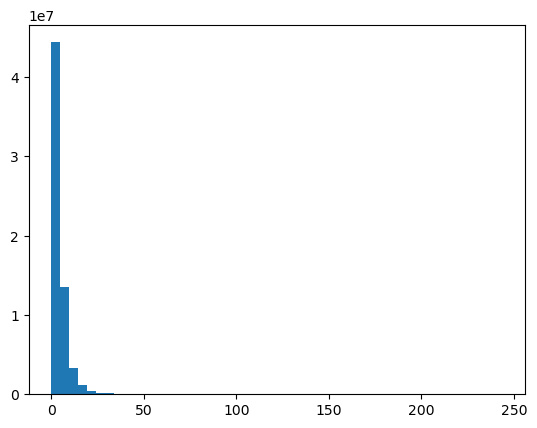

In [175]:
plt.hist(vars_wind, bins=50)

In [164]:
(vars_wind < 0.59).sum() / len(vars_wind)  # wind window var  < 5%

0.05020994196711314

In [173]:
(vars_wind > 12.2).sum() / len(vars_wind)  # wind window var  > 95%

0.049919757748250235

(array([ 490471., 2141673., 2858478., 3531837., 6517491., 7387220.,
        6693286., 4444106., 4535917., 3718632., 2551883., 2755908.,
        2324117., 1932725., 1338799., 1417608., 1201556.,  821548.,
         882407.,  752382.,  637963.,  447339.,  489418.,  422937.,
         294734.,  311870.,  261386.,  214294.,  143125.,  151616.,
         120304.,   90613.,   61076.,   83143.,   50365.,   34321.,
          36701.,   31834.,   29861.,   22514.,   28357.,   27055.,
          20551.,   26250.,   24047.,   30907.,   30180.,   58849.,
          57683.,  643218.]),
 array([0.01666667, 0.03633333, 0.056     , 0.07566667, 0.09533333,
        0.115     , 0.13466667, 0.15433333, 0.174     , 0.19366667,
        0.21333333, 0.233     , 0.25266667, 0.27233333, 0.292     ,
        0.31166667, 0.33133333, 0.351     , 0.37066667, 0.39033333,
        0.41      , 0.42966667, 0.44933333, 0.469     , 0.48866667,
        0.50833333, 0.528     , 0.54766667, 0.56733333, 0.587     ,
        0.60666667

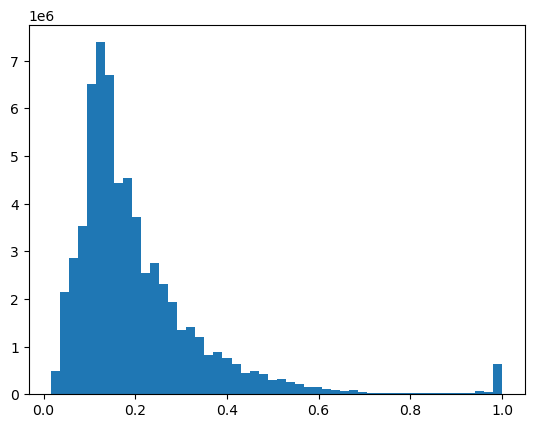

In [178]:
plt.hist(modes_wind, bins=50)

In [187]:
(modes_wind > 0.373).sum() / len(modes_wind)  #  wind window modes > 90%

0.10017938272305459